# Target-embedding autoencoders

In [1]:
import importlib
import numpy as np
import pandas as pd
import os
from pathlib import Path
from tqdm import tqdm

import torch
from torch import nn, optim, tensor, FloatTensor
from torch.utils.data import Dataset, TensorDataset, DataLoader

from data.skl_synthetic import make_skl_dataset, load_skl_data
# import models.linear
from models.linear import LinearAE, LinearMLP, MiniLinearMLP, LinearTEA
from plotting import plot_losses, plot_predicted_vs_actual

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

### Load data, set model paramaters 

In [3]:
home = Path.home()
path_for_data = home/"teas-data/sklearn/"
if not os.path.exists(path_for_data):
    make_skl_dataset()
if os.path.exists(path_for_data):
    X_train, X_valid, X_test, Y_train, Y_valid, Y_test = map(FloatTensor, load_skl_data(path_for_data))

In [4]:
batch_size = 128
train_ds = TensorDataset(X_train, Y_train)
valid_ds = TensorDataset(X_valid, Y_valid)
test_ds = TensorDataset(X_test, Y_test)
train_dl = DataLoader(train_ds, batch_size)
valid_dl = DataLoader(valid_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [5]:
# these give us some shape values for later
X, Y = next(iter(train_ds))
input_dim = X.shape[0]
hidden_dim = 128
output_dim = Y.shape[0]

First, train a simple linear autoencoder for $Y$

In [6]:
lae_model = LinearAE(output_dim, hidden_dim)

In [7]:
# train the linear AE
epochs = 20
lr = 5e-4
opt = optim.Adam(lae_model.parameters(), lr)
mse = nn.MSELoss()
train_loss, valid_loss = [], []

In [8]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([lae_model.update_batch(Y, opt, mse) for _, Y in train_dl])
    this_valid_loss = np.mean([lae_model.update_batch(Y, opt, mse, train=False) for _, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


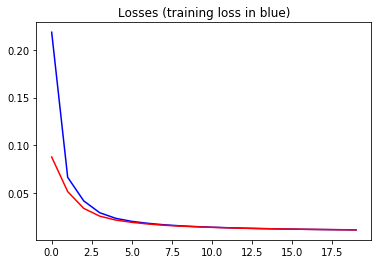

In [9]:
plot_losses(epochs, train_loss, valid_loss)

Visualise predicted vs. actual

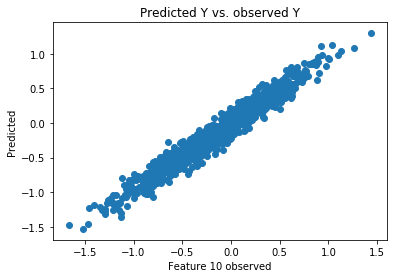

In [10]:
# pick a row, generate predictions
idx = 10
X, Y = valid_ds[idx]
# Y_hat, X_tilde = lfea_model(X)
Y_tilde = lae_model(Y)
plot_predicted_vs_actual(Y, Y_tilde, idx, title = "Predicted Y vs. observed Y")

Now we train a mini MLP to map $X$ to $Z$

In [11]:
mini_mlp_model = MiniLinearMLP(input_dim = 100, output_dim = 128)

In [12]:
epochs = 5
lr = 1e-0
opt = optim.Adam(mini_mlp_model.parameters(), lr)
mse = nn.MSELoss()
train_loss, valid_loss = [], []
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([mini_mlp_model.update_batch(X, lae_model.Z_from_X(Y), opt, mse) for X, Y in train_dl])
    this_valid_loss = np.mean([mini_mlp_model.update_batch(X, lae_model.Z_from_X(Y), opt, mse, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


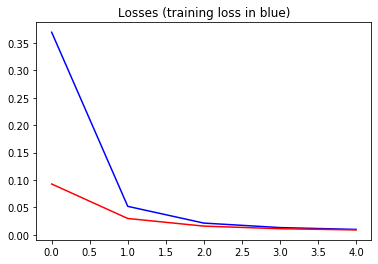

In [13]:
plot_losses(epochs, train_loss, valid_loss)

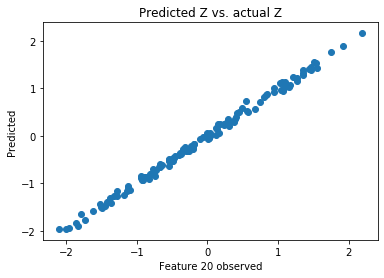

In [14]:
# pick a row, generate predictions
idx = 20
X, Y = valid_ds[idx]
Z = lae_model.Z_from_X(Y)
# Y_hat, X_tilde = lfea_model(X)
Z_hat = mini_mlp_model(X)
plot_predicted_vs_actual(Z, Z_hat, idx, title = "Predicted Z vs. actual Z")

Now compose the two functions and predict $y$

In [15]:
def compute_Y_hat(X): return(lae_model.X_from_Z(mini_mlp_model(X)))

In [21]:
# valid losses
valid_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in valid_ds:
    Y_hat = compute_Y_hat(X)
    valid_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

Final test MSE loss on prediction task: 0.015657126903533936


Now define our joint loss function and transfer these weights to a TEA

In [24]:
class JointLoss(nn.Module):
    """
    Parameters
    ----------
    lambda_ : float
        Weighting in the joint joss. 
        Lower lambda_ favours lower Y reconstruction loss (from Y via Z).
        Higher lambda_ favours lower loss predicting Z from X.
    """
    def __init__(self, lambda_=0.5):
        super().__init__()
        self.X = X
        self.Y = Y
        self.lambda_ = lambda_
        
    def forward(self, Y, Y_hat, Z, Z_hat):
        mse = nn.MSELoss()
        return ( ((1 - self.lambda_) * mse(Y_hat, Y)) + (self.lambda_ * mse(Z_hat, Z)) )

In [60]:
ltea_model = LinearTEA(input_dim, hidden_dim, output_dim)
ltea_model

LinearTEA(
  (input_X): Linear(in_features=100, out_features=128, bias=True)
  (input_Y): Linear(in_features=1000, out_features=128, bias=True)
  (predict_Y): Linear(in_features=128, out_features=1000, bias=True)
)

In [61]:
ltea_model.input_X.load_state_dict(mini_mlp_model.input_output.state_dict(), strict=True),\
ltea_model.input_Y.load_state_dict(lae_model.input.state_dict(), strict=True),\
ltea_model.predict_Y.load_state_dict(lae_model.output.state_dict(), strict=True)

(<All keys matched successfully>,
 <All keys matched successfully>,
 <All keys matched successfully>)

In [62]:
# train the linear TEA
epochs = 5
lr = 7e-3
opt = optim.Adam(ltea_model.parameters(), lr)
criterion = JointLoss(lambda_= .50)
train_loss, valid_loss = [], []

In [63]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([ltea_model.update_batch(X, Y, opt, criterion) for X, Y in train_dl])
    this_valid_loss = np.mean([ltea_model.update_batch(X, Y, opt, criterion, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


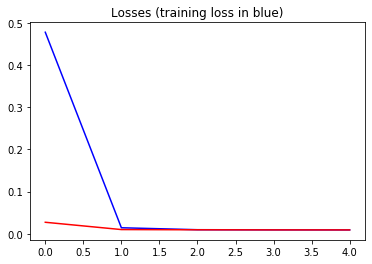

In [64]:
plot_losses(epochs, train_loss, valid_loss)

In [65]:
# valid losses
pred_error = []
for X, Y in valid_ds:
    pred_error.append(ltea_model.predict_Y_from_X(X).detach().numpy())
print("Valid MSE loss on prediction task: {}".format(np.mean(pred_error)))

Valid MSE loss on prediction task: 0.0031336687970906496


Results for different values of lambda:

| Lambda   | Final validation loss |
| :------- | :------------------   |
| 0.00     | 0.008518    |
| 0.25     | 0.010348   |
| 0.50     | 0.003133   |
| 0.75     | 0.003382   ||

### Test loss 

In [67]:
# test losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in test_ds:
    Y_hat = ltea_model.predict_Y_from_X(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

Final test MSE loss on prediction task: 0.014292663894593716


In [ ]:
gc.collect()